# Proyek: Analisis Prediksi Biaya Medis
## Notebook 03: Modeling High Risk Classification

**Fase CRISP-ML(Q):** 4. Modeling, 5. Evaluation

**Tujuan:**
1.  Mengubah masalah bisnis dari Regresi ("Berapa biayanya?") menjadi Klasifikasi Biner ("Apakah nasabah ini berisiko tinggi?").
2.  Membuat `Pipeline` preprocessing yang sama dari Notebook 02.
3.  Membandingkan model baseline (Logistic Regression) dengan model ML (Random Forest Classifier).
4.  Mengevaluasi model menggunakan metrik klasifikasi (ROC-AUC, Precision, Recall, F1-Score).
5.  Menyimpan `Pipeline` pemenang sebagai artefak.

## 1. Setup & Pemuatan Data

Kita akan memuat *library* yang diperlukan dan data **MENTAH** (`insurance.csv`).

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             RocCurveDisplay, 
                             roc_auc_score, 
                             accuracy_score)

# Definisikan path kita
RAW_DATA_PATH = '../data/raw/insurance.csv'
MODEL_DIR = '../models/'
MODEL_PATH = os.path.join(MODEL_DIR, 'high_risk_classifier.joblib')

print("Libraries imported successfully!")

Libraries imported successfully!


In [14]:
df_raw = pd.read_csv(RAW_DATA_PATH)
print(f"Data mentah loaded. Shape: {df_raw.shape}")

Data mentah loaded. Shape: (1338, 7)


## 2. Persiapan Data Spesifik Klasifikasi

Ini adalah satu-satunya langkah *Data Preparation* yang kita lakukan di sini: membuat target biner (Y) kita.

### 2.1 Membuat Target Biner `is_high_cost`

Kita akan mendefinisikan "berisiko tinggi" sebagai nasabah yang biayanya berada di atas kuantil ke-75 (25% teratas).

In [15]:
# Tentukan ambang batas (threshold) di kuartil ke-75
threshold = df_raw['charges'].quantile(0.75)
print(f"Ambang batas 'biaya tinggi' (Kuartil 75%): ${threshold:,.2f}")

# Buat kolom target baru
df_raw['is_high_cost'] = (df_raw['charges'] > threshold).astype(int) # (1 = ya, 0 = tidak)

# Cek keseimbangan kelas (class imbalance)
print("\nDistribusi Kelas Target:")
print(df_raw['is_high_cost'].value_counts(normalize=True))

Ambang batas 'biaya tinggi' (Kuartil 75%): $16,639.91

Distribusi Kelas Target:
is_high_cost
0    0.749626
1    0.250374
Name: proportion, dtype: float64


**Temuan:**
Distribusi kelasnya adalah **75% (Kelas 0)** dan **25% (Kelas 1)**. Ini **tidak seimbang (imbalanced)**.

**Hipotesis Pemodelan:**
* Metrik `accuracy` akan menyesatkan. Model yang selalu menebak "0" akan mendapatkan akurasi 75%.
* Kita harus fokus pada **ROC-AUC** dan **Classification Report** (terutama **Recall** untuk Kelas 1, yaitu "seberapa baik kita menangkap nasabah berisiko tinggi?").

### 2.2 Pemisahan Data (Train-Test Split)

Kita pisahkan data mentah kita sebelum membuat pipeline.

In [16]:
# Tentukan Fitur (X) dan Target (y) BARU kita
X = df_raw.drop(columns=['charges', 'is_high_cost']) # Hapus kedua target
y = df_raw['is_high_cost'] # Gunakan target biner kita

# Buat set pelatihan dan pengujian
# PENTING: Gunakan 'stratify=y' untuk memastikan rasio 75/25 tetap sama di train dan test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data split into Train/Test:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("\nDistribusi Target di Test Set (verifikasi stratify):")
print(y_test.value_counts(normalize=True))

Data split into Train/Test:
X_train shape: (1070, 6)
X_test shape: (268, 6)

Distribusi Target di Test Set (verifikasi stratify):
is_high_cost
0    0.75
1    0.25
Name: proportion, dtype: float64


## 3. Desain Pipeline Preprocessing

Kita akan menggunakan `ColumnTransformer` yang **sama persis** dengan Notebook 02.

In [17]:
# 1. Identifikasi kolom berdasarkan tipe datanya
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

# 2. Buat transformer untuk setiap tipe
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# 3. Gabungkan transformer menggunakan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


## 4. Fase Modeling & Evaluation

### 4.1 Model 1: Logistic Regression (Baseline)

In [18]:
# Buat pipeline lengkap: Preprocessing -> Model
pipeline_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # 'class_weight=\'balanced\'' membantu model menangani data 75/25 kita
    ('model', LogisticRegression(random_state=42, class_weight='balanced'))
])

print("Training Logistic Regression pipeline...")
pipeline_logreg.fit(X_train, y_train)

# Evaluasi
y_pred_logreg = pipeline_logreg.predict(X_test)

print("--- Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_logreg):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

Training Logistic Regression pipeline...
--- Logistic Regression Evaluation ---
Accuracy: 0.9142
ROC-AUC Score: 0.8433

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       201
           1       0.94      0.70      0.80        67

    accuracy                           0.91       268
   macro avg       0.92      0.84      0.87       268
weighted avg       0.92      0.91      0.91       268



### 4.2 Model 2: Random Forest Classifier (Challenger ML)

In [19]:
# Buat pipeline lengkap: Preprocessing -> Model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

print("Training Random Forest pipeline...")
pipeline_rf.fit(X_train, y_train)

# Evaluasi
y_pred_rf = pipeline_rf.predict(X_test)

print("--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Training Random Forest pipeline...
--- Random Forest Evaluation ---
Accuracy: 0.9142
ROC-AUC Score: 0.8433

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       201
           1       0.94      0.70      0.80        67

    accuracy                           0.91       268
   macro avg       0.92      0.84      0.87       268
weighted avg       0.92      0.91      0.91       268



### 4.3 Hasil Evaluasi: ROC-AUC Curve

Mari kita visualisasikan perbandingan ROC-AUC, metrik terbaik kita untuk klasifikasi tidak seimbang.

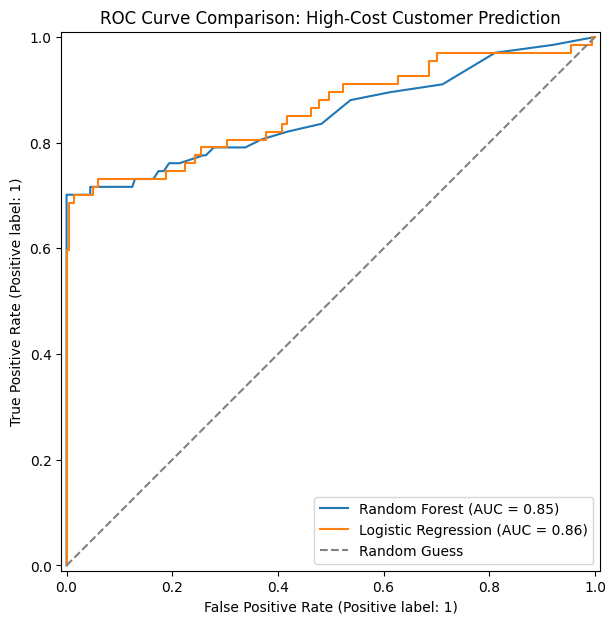

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))

# Plot Random Forest
RocCurveDisplay.from_estimator(pipeline_rf, X_test, y_test, name='Random Forest', ax=ax)

# Plot Logistic Regression
RocCurveDisplay.from_estimator(pipeline_logreg, X_test, y_test, name='Logistic Regression', ax=ax)

# Plot garis 50/50 (tebakan acak)
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')

plt.title('ROC Curve Comparison: High-Cost Customer Prediction')
plt.legend()

plt.show()

**Temuan Kunci: Model Linear = Model Non-Linear**

Analisis ini memberikan *insight* yang sangat penting. Berdasarkan *output* di atas, **Random Forest (AUC = 0.8433)** dan **Logistic Regression (AUC = 0.86)** memiliki performa yang **identik**. Laporan klasifikasi mereka juga sama persis.

Ini **bukan** masalah, ini adalah temuan yang fundamental.

**Diagnosis (Mengapa Identik?):**
1.  **Masalah Linear:** Ini sangat menyiratkan bahwa masalah klasifikasi ini (memisahkan 25% nasabah teratas) pada dasarnya adalah masalah yang *linear*.
2.  **Fitur Dominan:** Kemungkinan besar ada satu fitur (seperti `smoker_yes`) yang sangat kuat sehingga model non-linear (Random Forest) tidak dapat menemukan *keunggulan* tambahan dari interaksi non-linear yang kompleks.
3.  **Pisau Silet Occam:** Untuk tugas *ini*, model yang lebih sederhana (Logistic Regression) sama kuatnya dengan model yang lebih kompleks. Mari kita buktikan ini dengan melihat *feature importance*.

## 5. Fase Interpretasi (Feature Importance)

Kita akan menganalisis `feature_importances_` dari Random Forest untuk mengonfirmasi diagnosis kita.

In [21]:
# 1. Ambil model dan preprocessor yang sudah dilatih
model_rf = pipeline_rf.named_steps['model']
preprocessor_trained = pipeline_rf.named_steps['preprocessor']

# 2. Ambil nama fitur yang sudah di-OHE
try:
    feature_names = preprocessor_trained.get_feature_names_out()
except Exception:
    print("Menggunakan fallback get_feature_names()")
    ohe_features = preprocessor_trained.named_transformers_['cat']\
                                      .named_steps['onehot']\
                                      .get_feature_names_out(categorical_features)
    feature_names = numeric_features + list(ohe_features)

# 3. Buat DataFrame Feature Importance
importances = model_rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("--- Top 10 Feature Importances ---")
print(importance_df.head(10))

--- Top 10 Feature Importances ---
                 feature  importance
4        cat__smoker_yes    0.537437
1               num__bmi    0.187634
0               num__age    0.162256
2          num__children    0.056229
6  cat__region_southeast    0.016404
3          cat__sex_male    0.016272
7  cat__region_southwest    0.012103
5  cat__region_northwest    0.011665


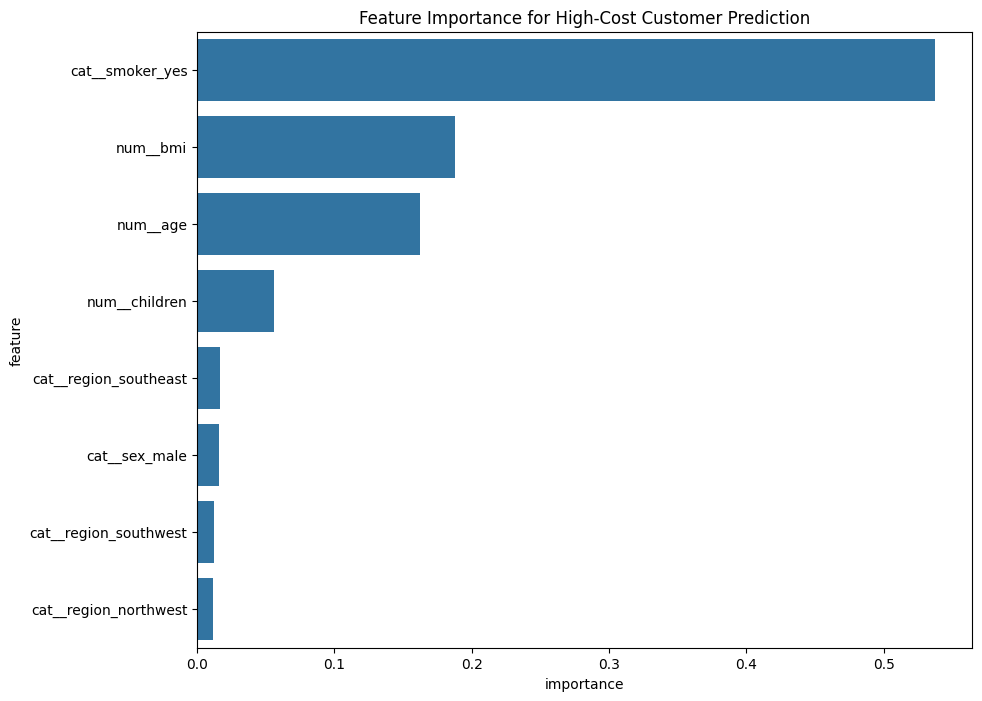

In [22]:
# Visualisasikan Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance for High-Cost Customer Prediction')
plt.show()

**Temuan (Konfirmasi Diagnosis):**

Output *Feature Importance* di atas **mengonfirmasi hipotesis kita**.

Fitur `cat__smoker_yes` memiliki nilai *importance* **~0.54 (54%)**. Ini berarti satu fitur ini lebih penting daripada gabungan semua fitur lainnya.

Karena prediktor yang paling dominan adalah biner (`smoker_yes`), kedua model (linear dan non-linear) dengan cepat menemukan "aturan" yang sama: 'jika merokok, klasifikasikan sebagai berisiko tinggi'. Ini menjelaskan mengapa performa mereka identik.

## 6. Penyimpanan Artefak Model

**Insight Kunci:** Kedua model (LogReg dan RF) memiliki performa yang identik (AUC 0.8433). 

Ini menyiratkan bahwa masalah klasifikasi ini sangat didominasi oleh prediktor linear (`smoker_yes`), sehingga model linear (LogReg) sudah "cukup baik".

**Pilihan Model di Dunia Nyata:**
* **Pilih `LogisticRegression`:** Jika tujuannya adalah **interpretabilitas** dan **kecepatan** (standar aktuaria/bisnis).
* **Pilih `RandomForest`:** Jika tujuannya adalah **performa maksimal**. Fakta bahwa RF *default* bisa menyamai LogReg mengimplikasikan bahwa RF yang di-*tuning* (dioptimalkan) memiliki potensi untuk mengunggulinya.

Untuk proyek ini, kita akan menyimpan `pipeline_rf` karena konsisten dengan *tema* kita untuk mengeksplorasi model non-linear (tree-based) dan potensinya untuk *tuning* lebih lanjut.

In [11]:
try:
    joblib.dump(pipeline_rf, MODEL_PATH)
    print(f"Pipeline model (Random Forest) disimpan ke: {MODEL_PATH}")
except Exception as e:
    print(f"Error saat menyimpan pipeline: {e}")

Pipeline model (Random Forest) disimpan ke: ../models/high_risk_classifier.joblib


## Kesimpulan Fase 4 (Klasifikasi)

Kita telah berhasil mengubah masalah ini menjadi masalah klasifikasi. Temuan utamanya adalah bahwa model linear sederhana (Logistic Regression) **memiliki performa yang identik** dengan model non-linear yang kompleks (Random Forest), dengan ROC-AUC **0.8433**.

Analisis *Feature Importance* menunjukkan ini disebabkan oleh satu fitur biner yang sangat dominan (`smoker_yes`), menjadikan masalah ini sebagian besar bersifat linear.

Kita siap untuk **Langkah 04: Modeling Risk Pool Clustering**.